- $\textbf{Author}$: Patrick L. Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# CREDIT CARD FRAUD DETECTION:
 
 Data for the project was sourced from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud.
 
Project context: "It is important that credit card companies are able to recognise fraudulent credit card transactions so that customers are not charged for items they did not purchase." kaggle.
 
Content: "The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification." kaggle.

Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project


# OBJECTIVES: 

In this project, we investigated a suite of weighted machine learning methods that are commonly used to address skewed class distributions. Also investigated are data sampling approaches to address class imbalance. The following aspects are addressed in this project:
- Exploring the credit card dataset using Dtale explanator data explorer.
- Framing the fraud detection problem, developing a test harness and evaluating the baseline model. 
- Exploring a set of weighted machine learning algorithms and ensembles.
- Exploring a suite of data sampling methods to address class imbalance.
- In imbalanced classification problems such as fraud detection, the cost of misclassifying a fraudulent transaction as non-fraudulent (a false negative, FN) is typically higher than misclassifying a legitimate transaction as fraudulent (a false positive, FP). As a result, this project prioritizes optimizing recall—the true positive rate—to maximize the detection of fraudulent cases, even if it comes at the expense of precision. This reflects a deliberate trade-off that favors identifying as many true frauds as possible, accepting a higher false alarm rate.
- Implementing Bayesian hyperparameter searching based on the recall score to get a better coverage of fraudulent transactions.
- Determining the optimal threshold based on F2-measure:
$$\text{F2-measure} = \frac{(1 + 2^2) \times (\text{precision} \times \text{recall})}{(2^2 \times \text{precision} + \text{recall})}$$

   - This metric applies more weight to recall to limit FN, i.e., legitimate fraud cases misclassified as non-fraud, and
- Finalising and potential improvements.

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd

from collections import Counter

import dtale

from pandas import json_normalize
import pickle

import sklearn
from sklearn.preprocessing import RobustScaler, LabelEncoder, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, auc

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll import scope
import logging

from tqdm import tqdm
import warnings

# matplotlib configuration:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', 
              style='whitegrid',
              palette='colorblind', 
              color_codes=True, 
              rc={'figure.figsize': [10, 6]})

In [2]:
# load the dataset:
filename = 'creditcard.csv'
credit_dta = pd.read_csv(filename, na_values="")
credit_dta.drop(columns=['Time'], inplace=True)
print(credit_dta.shape)
target = credit_dta.Class.values
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print('Class=%d: Count=%d, Percentage=%.2f%%' % (k, v, per))

(284807, 30)
Class=0: Count=284315, Percentage=99.83%
Class=1: Count=492, Percentage=0.17%


In [3]:
dtale.show(credit_dta, host='localhost')

# Evaluate base model

In [4]:
# config
RANDOM_STATE = 42
TEST_SIZE = 0.2

def get_data(data, target):
    X = data.copy()
    y = X.pop(target)
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_STATE
    )
    return X_train, X_test, y_train, y_test

def evaluate_model(X_train, X_test, y_train, y_test, model, display_plot=False):
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
    model.fit(X_train, y_train)
    model_perf = performance_evaluation_report(model, X_test, y_test, 
                                               labels=["No Fraud", "Fraud"], 
                                               show_plot=display_plot, show_pr_curve=display_plot)
    return model_perf
    
X_train, X_test, y_train, y_test = get_data(credit_dta, 'Class')
print(X_train.shape, y_train.shape, Counter(y_train))
print(X_test.shape, y_test.shape, Counter(y_test))
model = DummyClassifier(strategy='uniform')
model_perf = evaluate_model(X_train, X_test, y_train, y_test, model)
print('%s recall score: %.3f, average precision: %.3f, pr auc: %.3f' %  \
      ('Baseline', model_perf["recall"], model_perf["average_precision"], model_perf["pr_auc"]))

(227845, 29) (227845,) Counter({0: 227451, 1: 394})
(56962, 29) (56962,) Counter({0: 56864, 1: 98})
Baseline recall score: 0.378, average precision: 0.002, pr auc: 0.501


# Evaluate a suite of weighted machine learning algorithms and ensembles

In [8]:
# import machine learning algorithms
warnings.filterwarnings(
    "ignore",
    message=r".*'force_all_finite' was renamed to 'ensure_all_finite' in 1.6.*",
    category=FutureWarning,
    module=r".*sklearn.*"
)

N_FOLDS = 5
cv_scheme = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def get_stacking():
    level0 = []
    level0.append(
        ('lr', make_pipeline(PowerTransformer(), LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)))
    )
    level0.append(('svm', SVC(class_weight='balanced', random_state=RANDOM_STATE)))
    level0.append(('dtree', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)))
    level0.append(('rf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)))
    level0.append(('lgbm', LGBMClassifier(class_weight="balanced", n_jobs=-1, verbose=-1)))
    leve1 = LogisticRegression()
    stacking_ensemble = StackingClassifier(estimators=level0, final_estimator=leve1, cv=cv_scheme)
    return stacking_ensemble

def get_models():
    models = {}
    models['lr'] = make_pipeline(
        PowerTransformer(), LogisticRegression(class_weight='balanced')
    )
    models['svm'] = CalibratedClassifierCV(SVC(gamma='scale', class_weight='balanced'),method="sigmoid", cv=cv_scheme)
    models['dtree'] = DecisionTreeClassifier(class_weight='balanced')
    models['rf'] = RandomForestClassifier(class_weight='balanced')
    models['lgbm'] = LGBMClassifier(class_weight="balanced", n_jobs=-1, verbose=-1)
    models['stacking'] = get_stacking()
    return models

models = get_models()
performance_results = {}
for name, clf in tqdm(models.items(), ncols=100, desc="Model Eval."):
    params = clf.get_params()
    
    if "n_jobs" in params:
        clf.set_params(n_jobs=-1)
    if "random_state" in params:
        clf.set_params(random_state=RANDOM_STATE)

    model_perf = evaluate_model(X_train, X_test, y_train, y_test, clf)
    performance_results[name] = model_perf

df = pd.DataFrame(performance_results).T
df.style.highlight_max(axis=0, color="lightblue")

Model Eval.:  83%|███████████████████████████████████████████▎        | 5/6 [08:13<01:04, 64.53s/it]/home/pmthisi/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmthisi/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmthisi/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmthisi/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pmthisi/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:1

,accuracy,precision,recall,specificity,f1_score,cohens_kappa,matthews_corr_coeff,roc_auc,pr_auc,average_precision
lr,0.972455,0.054512,0.918367,0.972549,0.102916,0.099993,0.220084,0.972623,0.744823,0.712388
svm,0.998473,0.823529,0.142857,0.999947,0.243478,0.243093,0.342627,0.975099,0.511642,0.514053
dtree,0.998999,0.707071,0.714286,0.999490,0.710660,0.710159,0.710168,0.856888,0.710924,0.505542
rf,0.999526,0.961039,0.755102,0.999947,0.845714,0.845480,0.851653,0.958010,0.857157,0.848280
lgbm,0.999333,0.777778,0.857143,0.999578,0.815534,0.815201,0.816166,0.970399,0.870353,0.870484
stacking,0.999491,0.896552,0.795918,0.999842,0.843243,0.842989,0.844488,0.977238,0.862645,0.862902


# Handling class imbalance using data sampling

In [9]:
# implementing data sampling strategies
from imblearn.pipeline import Pipeline

# define data sampling models
def get_models():
    models = dict()
    models['smote'] = SMOTE()
    models['borderline'] = BorderlineSMOTE()
    models['svmsmote'] = SVMSMOTE()
    models['adasyn'] = ADASYN()
    return models


models = get_models()
classifier = LGBMClassifier(n_jobs=-1, verbose=-1)
performance_results = {}
for name, model in tqdm(models.items(), ncols= 100,  desc="Model Eval."):
    steps = list()
    steps.append(('sampling_strategy', model))
    steps.append(('clf', classifier))
    pipeline = Pipeline(steps=steps)
    model_perf = evaluate_model(X_train, X_test, y_train, y_test, pipeline)
    performance_results[name] = model_perf
    
df = pd.DataFrame(performance_results).T
df.style.highlight_max(axis=0, color="lightblue")

Model Eval.: 100%|████████████████████████████████████████████████████| 4/4 [02:15<00:00, 33.82s/it]


,accuracy,precision,recall,specificity,f1_score,cohens_kappa,matthews_corr_coeff,roc_auc,pr_auc,average_precision
smote,0.998192,0.485714,0.867347,0.998417,0.622711,0.621877,0.648318,0.959532,0.846139,0.844175
borderline,0.999350,0.785047,0.857143,0.999596,0.819512,0.819187,0.819981,0.973486,0.852604,0.852850
svmsmote,0.999175,0.738318,0.806122,0.999508,0.770732,0.770319,0.771065,0.944153,0.674177,0.682076
adasyn,0.996910,0.341463,0.857143,0.997151,0.488372,0.487110,0.539907,0.943461,0.842592,0.842701


# Bayesian hyperparameter optimisation

In [11]:
from imblearn.pipeline import Pipeline

# config
EVAL_METRIC = "recall"
MAX_EVALS = 200

logging.getLogger("hyperopt").setLevel(logging.WARNING)

def objective(params, n_folds=N_FOLDS, random_state=RANDOM_STATE, metric=EVAL_METRIC):
    clf = LGBMClassifier(**params, random_state=random_state, n_jobs=-1, verbose=-1)
    model = Pipeline(steps=[
        ("sampling", SMOTE()),
        ("classifier", clf)        
    ])
    cv = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=metric)
    loss = -1 * scores.mean()
    
    return {"loss": loss, "params": params, "status": STATUS_OK}

search_space = {
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "rf"]),
    "max_depth": scope.int(hp.uniform("max_depth", 3, 20)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "n_estimators": hp.choice("n_estimators", [500, 1000]),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1.0),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),   
}

trials = Trials()
best_set = fmin(fn=objective,
                space=search_space,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials,
                rstate=np.random.default_rng(RANDOM_STATE))

100%|█████████████████████████████████| 200/200 [27:06:20<00:00, 487.90s/trial, best loss: -0.8935086011035379]                                                                                                     


In [20]:
# save optimization results:
pickle.dump(trials, open("model_search_space.p", "wb"))

In [40]:
results_df = pd.DataFrame(trials.results)
params_df = json_normalize(results_df["params"])
results_df = pd.concat([results_df.drop("params", axis=1), params_df], axis=1)
results_df["iteration"] = np.arange(len(results_df)) + 1
results_df.sort_values("loss").iloc[:5]

,loss,status,boosting_type,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,iteration
145,-0.893509,ok,dart,0.789316,0.026144,3,1000,0.899891,0.410331,146
148,-0.890977,ok,dart,0.935111,0.021805,3,1000,0.976875,0.275108,149
93,-0.890977,ok,dart,0.633124,0.057606,3,500,0.068075,0.115376,94
146,-0.888445,ok,dart,0.895472,0.027118,3,1000,0.964284,0.176963,147
94,-0.888445,ok,dart,0.482497,0.057550,3,500,0.083858,0.145838,95


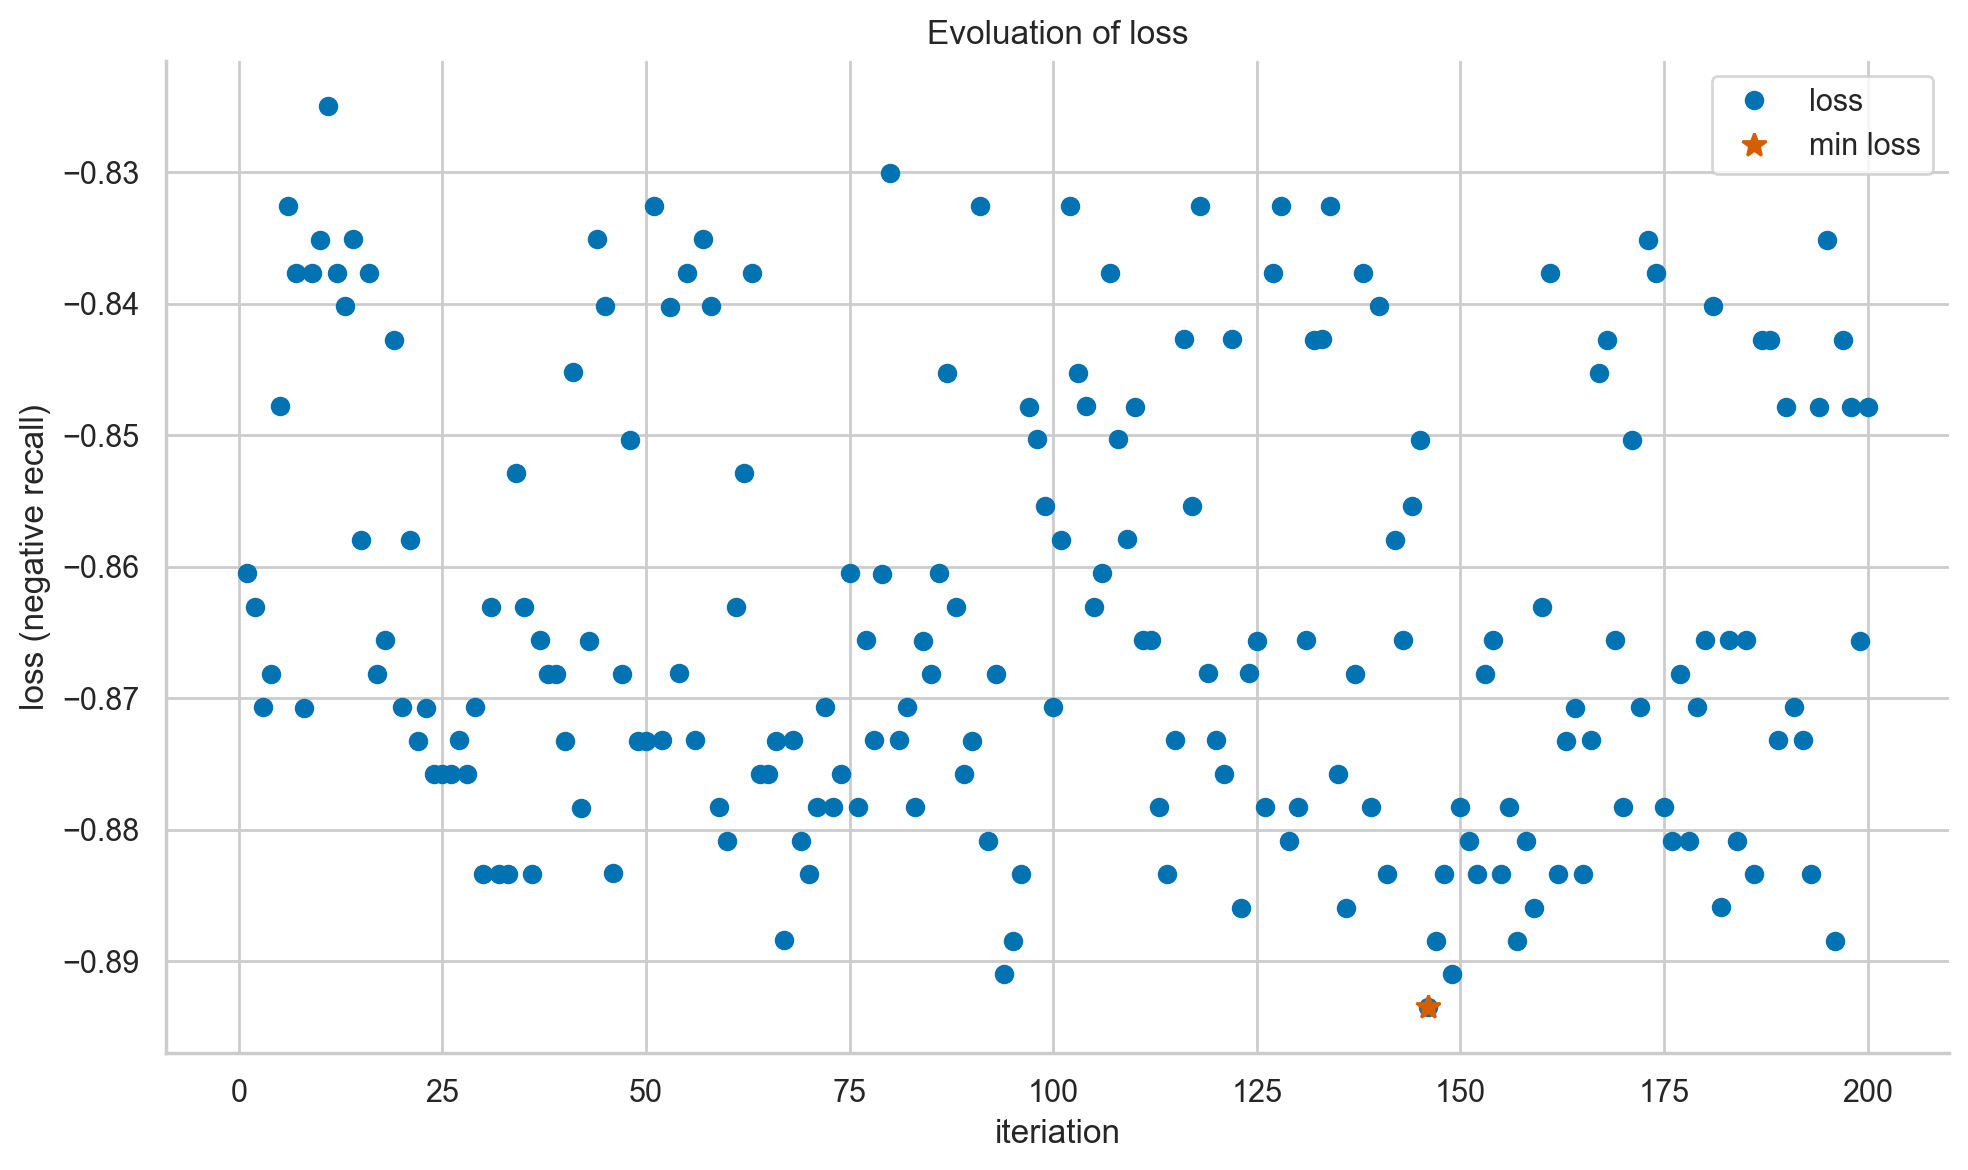

In [89]:
best_ind = results_df["loss"].argmin()

fig, ax = plt.subplots()
ax.plot(results_df["iteration"], results_df["loss"], "o")
ax.plot(results_df["iteration"].iloc[best_ind], results_df["loss"].iloc[best_ind], "r*", markersize=9, label="loss")
ax.set(title="Evoluation of loss", xlabel="iteriation", ylabel="loss (negative recall)", label="min loss")
labels = ["loss", "min loss"]
ax.legend(labels)

sns.despine()
plt.tight_layout()

# Evaluate tuned model

In [77]:
# save 
pickle.dump(trials, open("model_search_space.p", "wb"))

Tuned Model's recall:0.9082


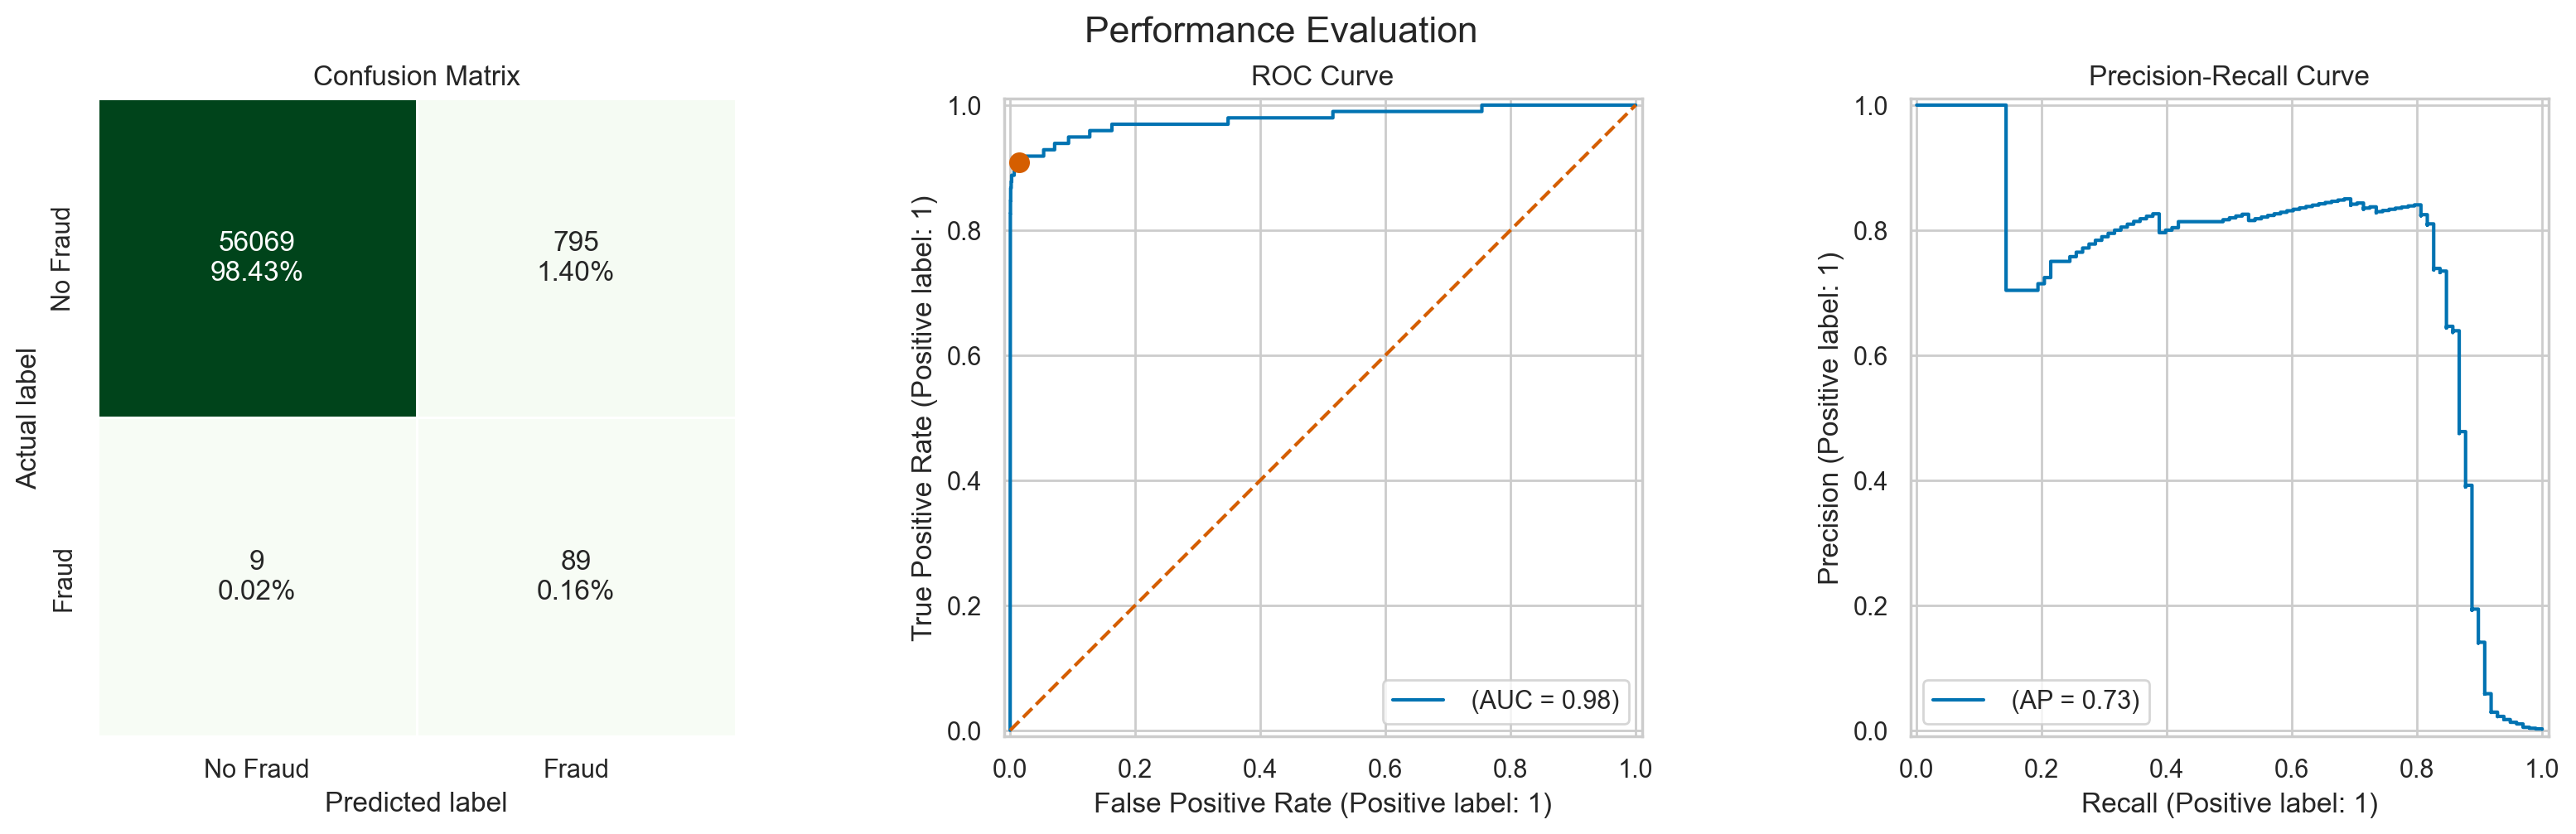

In [79]:
from imblearn.pipeline import Pipeline
tuned_clf = LGBMClassifier(**space_eval(search_space, best_set), 
                            random_state=RANDOM_STATE, 
                            n_jobs=-1, 
                            verbose=-1)

tuned_pipeline = Pipeline(steps=[
    ("sampling", SMOTE()),
    ("clf", tuned_clf)
    
])

tuned_pipeline_perf = evaluate_model(X_train, X_test, y_train, y_test, tuned_pipeline, display_plot=True)
print("Tuned Model's recall:%.4f" % (tuned_pipeline_perf["recall"]))

# Determining the optimal threshold using the best model

Threshold: 0.97653, Fbeta-score: 0.823


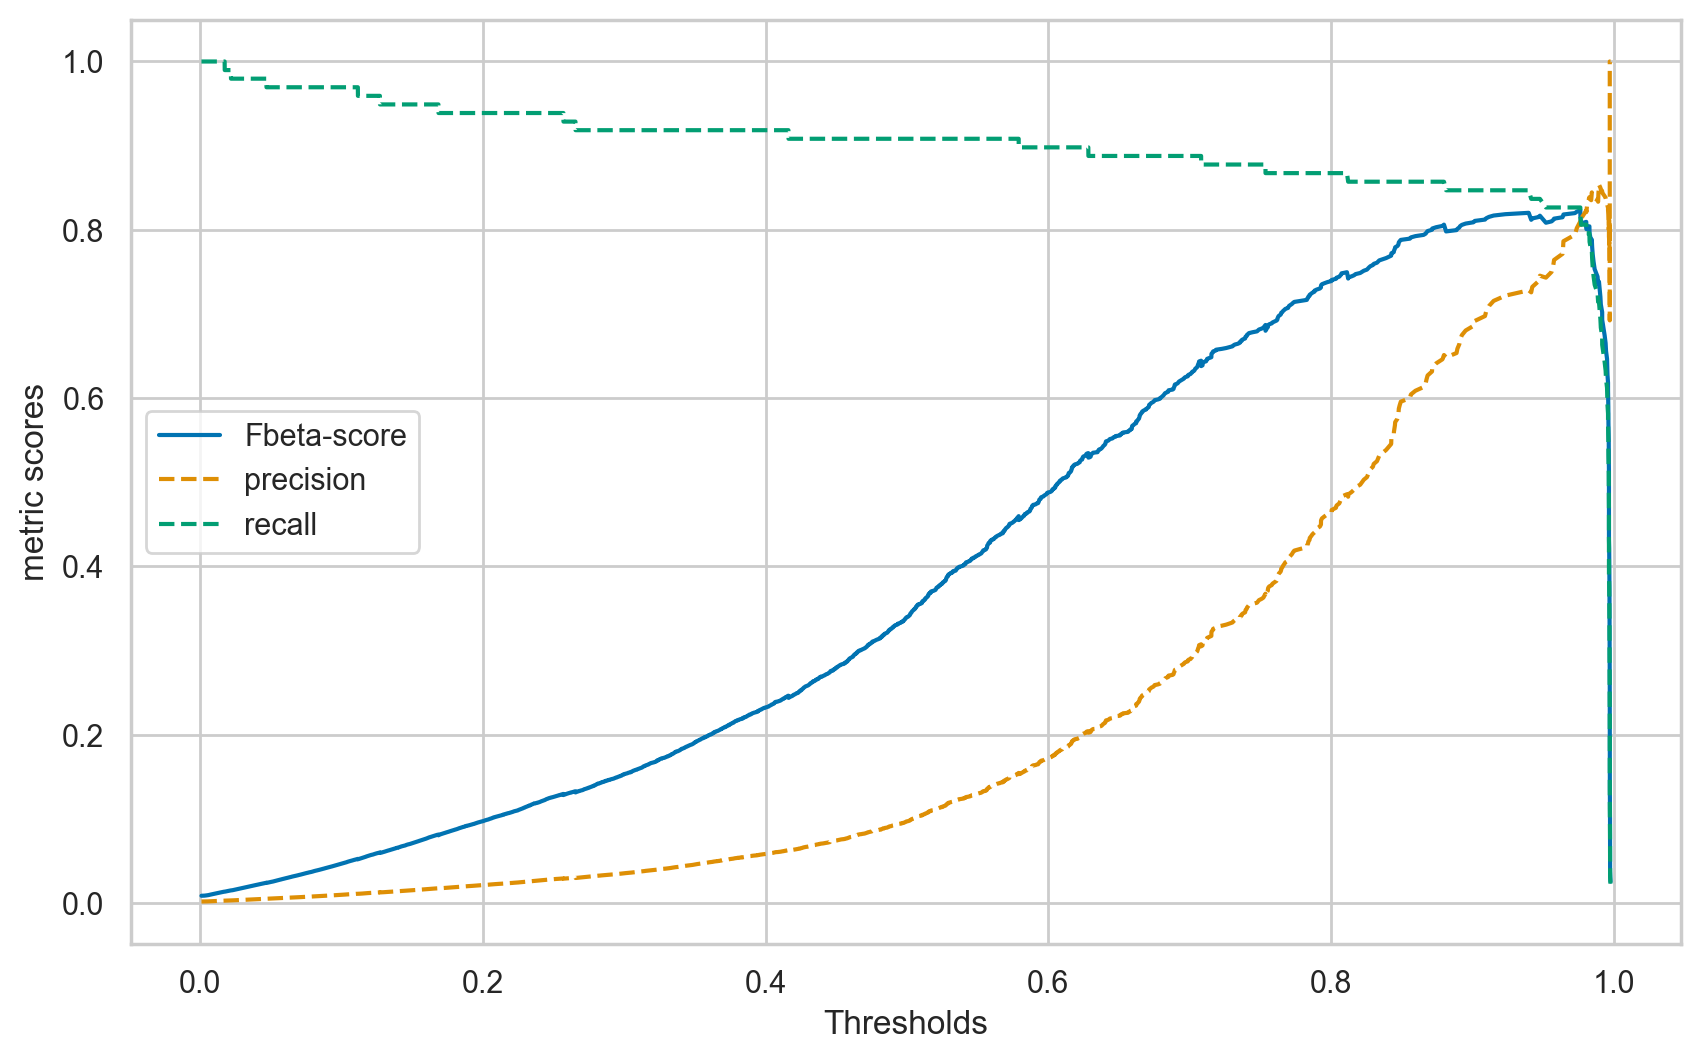

In [83]:
# calculate Fbeta-score and locate the index for maximum Fbeta-score
def evaluate_tuned_model(X_train, X_test, y_train, y_test, model):
    scaler = RobustScaler()
    scaler.fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
    model.fit(X_train, y_train)
    model_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, threshold = precision_recall_curve(y_test, model_probs)
    pr_auc = auc(recall, precision)
    return precision, recall, threshold, pr_auc

precision, recall, threshold, pr_auc = evaluate_tuned_model(X_train, X_test, y_train, y_test, tuned_pipeline)

beta = 2
Fbeta_score = (1+beta**2) * (precision * recall) / (beta**2 * precision + recall)
idx_max = np.argmax(Fbeta_score)
# print the optimal threshold and the corresponding fbeta-score 
print('Threshold: %.5f, Fbeta-score: %.3f' % (threshold[idx_max], Fbeta_score[idx_max]))

plt.plot(threshold, Fbeta_score[:-1], label = 'Fbeta-score')
plt.plot(threshold, precision[:-1], label = 'precision', linestyle='--')
plt.plot(threshold, recall[:-1], label = 'recall', linestyle='--')
plt.xlabel('Thresholds')
plt.ylabel('metric scores')
plt.legend()
plt.show()

# Where do we go from here?
- In this highly skewed fraud investigation dataset, the SMOTE + LGMClassifier pipeline produced the highest recall score without causing a significant deterioration in other metrics considered, achieving a recall of 0.867 and pr AUC of 0.846. As we are interested in attaining more coverage of fraudulent cases, we implemented Bayesian hyperparameter optimisation, using negative recall as the objective function (i.e., $\text{min} \big(-f(x)\big) = \text{max} \big(f(x)\big)$). 
- Based on the optimal set of hyperparameters, we managed to boost the recall score to 0.908 at the expense of precision. As can be seen from the confusion matrix, our model managed to correctly classify most of the fraudulent causes in the test set.  
- Instead of using SMOTE, one could also explore BorderlineSMOTE in further work. Even better, one could optimise recall based on weighted machine learning models which achieved good performance in this study. It will be interesting to see how the results compare. 
- Furthermore, one can explore one-class algorithms in this work as well. The ones that l can think of are isolation forests or one-class support vector machines. Due to the severe class imbalance, l believe these algorithms could yield very interesting and useful results.